[View in Colaboratory](https://colab.research.google.com/github/dthoma8/ratsinthecity/blob/master/Rats_in_the_City_Exploratory_Analysis_&_Choropleth_Map.ipynb)

# Rats in the City

##### Libraries
<a id = "libs"></a>

In [0]:
import os
import requests
import glob

import pandas as pd
import geopandas as gpd
import numpy as np
from math import pi

###### Get Data
---
NYC Open Data link

In [2]:
data_url = "https://nycopendata.socrata.com/api/views/3q43-55fe/rows.csv?accessType=DOWNLOAD"
def download_data(url, path="data", name="Rat_Sightings.csv"):
    
    if not os.path.exists(path):
        os.mkdir(path)
    
    response=requests.get(url)

    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)
        
download_data(url=data_url)
os.listdir("./data/")

['f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson',
 'neighborhoods.htm',
 'Rat_Sightings.csv']

###### ratty data..

* read in data and take some first looks
<a id = "load_data"></a>

In [3]:
# read in rat sightings data
df = pd.read_csv("./data/Rat_Sightings.csv")
print(df.shape)
print(df.info())
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(115451, 38)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115451 entries, 0 to 115450
Data columns (total 38 columns):
Unique Key                        115451 non-null int64
Created Date                      115451 non-null object
Closed Date                       103862 non-null object
Agency                            115451 non-null object
Agency Name                       115451 non-null object
Complaint Type                    115451 non-null object
Descriptor                        115451 non-null object
Location Type                     115445 non-null object
Incident Zip                      115069 non-null float64
Incident Address                  105490 non-null object
Street Name                       105489 non-null object
Cross Street 1                    94646 non-null object
Cross Street 2                    94609 non-null object
Intersection Street 1             9782 non-null object
Intersection Street 2             9782 non-null object
Address Type               

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,15633054,01/01/2010 11:20:45 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,1-2 Family Dwelling,11365.0,59-13 159 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.739983,-73.809299,"(40.73998332248969, -73.80929891501533)"
1,15633304,01/02/2010 12:50:36 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Commercial Building,10016.0,2 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.743161,-73.976983,"(40.74316088098852, -73.97698314758436)"
2,15633594,01/01/2010 03:05:37 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,11377.0,31-14 58 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.756987,-73.903618,"(40.756986581184535, -73.90361811283164)"
3,15633599,01/01/2010 08:52:19 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,Other (Explain Below),11201.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.688903,-73.980929,"(40.68890317557533, -73.98092864957985)"
4,15633605,01/01/2010 04:14:27 PM,NaN,DOHMH,Department of Health and Mental Hygiene,Rodent,Rat Sighting,3+ Family Apt. Building,10467.0,2504 BRONX PARK EAST,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.863614,-73.870441,"(40.8636140600279, -73.87044117516707)"


##### Initial Data Processing

- We really want to make sure that we don't have any nulls in the zip code level as this is the backbone of our analysis. We will exclude any nulls that exist. 
- Additionally, there are only a few columns that are relevant to this analysis so we will proceed with those. 
<a id = "wrangling"></a>

In [4]:
# we want our data be viewed at the zip code level so thereforte
# we don't want any indices where the zip code is not provided
df = df[np.isfinite(df["Incident Zip"])]
# also, only a few columns are of importance
df = df[["Created Date", "Location Type", "Incident Zip", "Location"]]
df.head()

,Created Date,Location Type,Incident Zip,Location
0,01/01/2010 11:20:45 AM,1-2 Family Dwelling,11365.0,"(40.73998332248969, -73.80929891501533)"
1,01/02/2010 12:50:36 AM,Commercial Building,10016.0,"(40.74316088098852, -73.97698314758436)"
2,01/01/2010 03:05:37 PM,3+ Family Apt. Building,11377.0,"(40.756986581184535, -73.90361811283164)"
3,01/01/2010 08:52:19 PM,Other (Explain Below),11201.0,"(40.68890317557533, -73.98092864957985)"
4,01/01/2010 04:14:27 PM,3+ Family Apt. Building,10467.0,"(40.8636140600279, -73.87044117516707)"


In [5]:
df["Incident Zip"] = df["Incident Zip"].astype('str', copy=False)
# whenever I convert the column directly into integers, there
# appears to be a lost of values where their original values
# are modified or deleted. So by converting it string it should
# keep the values as is. Then I am going to run a str.split() fun
# to remove the decimals and reassign it back to the column

def remove_dec(row):
    
    return str(row).split(".")[0]

#remove decimals
df["Incident Zip"] = df["Incident Zip"].map(remove_dec)
df["Incident Zip"].head()

0    11365
1    10016
2    11377
3    11201
4    10467
Name: Incident Zip, dtype: object

In [6]:
#rename the col
df.rename(columns = {"Incident Zip":"postalCode"}, inplace=True)
# all the  columns in this dataset are string
for col in df.columns:
    if col != "postalCode":
        df[col] = df[col].astype("str", copy=False)
    else:
        df["postalCode"] = df["postalCode"].astype("int64", copy=False)
        
df = df.sort_values("postalCode")
df.head()

,Created Date,Location Type,postalCode,Location
112023,08/14/2017 12:00:00 AM,Other (Explain Below),83,"(40.78401193763258, -73.96968924461568)"
51122,08/26/2014 12:00:00 AM,Other (Explain Below),83,"(40.78286341773367, -73.96535663892631)"
51698,09/15/2014 12:00:00 AM,Other (Explain Below),83,"(40.7794758468835, -73.97357287287964)"
94705,09/06/2016 12:00:00 AM,Other (Explain Below),83,"(40.779741551985495, -73.97133770013274)"
95323,09/16/2016 12:00:00 AM,Other (Explain Below),83,"(40.7974659648698, -73.95170030179558)"


###### Let's Bring in Neighborhoods

* I'd like to add in another level at which the data can be looked at. Currently, the data has borough and zip code. I'd like to bring in the neighborhood (and i'll just bring in the borough data from the incoming file as well). 
<a id = "web_parsing"></a>

In [7]:
# url 
url = "https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm"

def download_data(url, path="data"):
    
    if not os.path.exists(path):
        os.mkdir(path)
    response = requests.get(url)
    name = os.path.basename(url)
    
    with open(os.path.join(path, name), "wb") as f:
        f.write(response.content)

# run the function to download the data 
download_data(url)

# read in the web page file
from bs4 import BeautifulSoup as bs

soup = bs(open("./data/neighborhoods.htm"), "html.parser")
soup

<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Strict//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-strict.dtd">

<!-- INCLUDE HEADER Version 1.05 7/26/2007 PAGE LAST MODIFIED Monday, 23-Feb-2015 12:15:40 EST -->
<html lang="en-us" xml:lang="en-us" xmlns="http://www.w3.org/1999/xhtml">
<head>
<title>NYC Neighborhood ZIP Code Definitions</title>
<meta content="Definitions of New York City Neighborhoods" name="description"/>
<meta content="neighborhood, Neighborhood, New York City, new york city,new york state, New York State" name="keywords"/>
<!-- THE FOLLOWING STYLE TAG IS FOR IMPORTING STYLE ONLY -->
<style type="text/css">
<!--
-->
</style>
<!-- -->
<!-- -->
<!-- -->
<!-- -->
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="IE=edge" http-equiv="x-ua-compatible"/>
<link href="/style/twenty16/main.css" media="screen" rel="stylesheet"/>
<link href="/style/twenty16/visualizations.css" m

###### We will need to select the table out of the page. 
<a id = "get_table"></a>

In [8]:
table = soup.find_all("table")[0]
table

<table summary=" ">
<tr>
<th abbr="Borough" id="header1">Borough</th>
<th abbr="Neighborhood" id="header2">Neighborhood</th>
<th abbr="ZIP Codes" id="header3">ZIP Codes</th>
</tr><tr>
<td headers="header1" rowspan="7">Bronx</td>
<td headers="header2"> Central Bronx</td>
<td headers="header3"> 10453, 10457, 10460</td>
</tr><tr>
<td headers="header2"> Bronx Park and Fordham</td>
<td headers="header3"> 10458, 10467, 10468</td>
</tr><tr>
<td headers="header2"> High Bridge and Morrisania</td>
<td headers="header3"> 10451, 10452, 10456</td>
</tr><tr>
<td headers="header2"> Hunts Point and Mott Haven</td>
<td headers="header3"> 10454, 10455, 10459, 10474</td>
</tr><tr>
<td headers="header2"> Kingsbridge and Riverdale</td>
<td headers="header3"> 10463, 10471</td>
</tr><tr>
<td headers="header2"> Northeast Bronx</td>
<td headers="header3"> 10466, 10469, 10470, 10475</td>
</tr><tr>
<td headers="header2"> Southeast Bronx</td>
<td headers="header3"> 10461, 10462,10464, 10465, 10472, 10473</td>
</t

In [9]:
nyc_data = []
for i in table.find_all("td"):
    nyc_data.append(i.string)
    
nyc_data

['Bronx',
 ' Central Bronx',
 ' 10453, 10457, 10460',
 ' Bronx Park and Fordham',
 ' 10458, 10467, 10468',
 ' High Bridge and Morrisania',
 ' 10451, 10452, 10456',
 ' Hunts Point and Mott Haven',
 ' 10454, 10455, 10459, 10474',
 ' Kingsbridge and Riverdale',
 ' 10463, 10471',
 ' Northeast Bronx',
 ' 10466, 10469, 10470, 10475',
 ' Southeast Bronx',
 ' 10461, 10462,10464, 10465, 10472, 10473',
 'Brooklyn',
 ' Central Brooklyn',
 ' 11212, 11213, 11216, 11233, 11238',
 ' Southwest Brooklyn',
 ' 11209, 11214, 11228',
 ' Borough Park',
 ' 11204, 11218, 11219, 11230',
 ' Canarsie and Flatlands',
 ' 11234, 11236, 11239',
 ' Southern Brooklyn',
 ' 11223, 11224, 11229, 11235',
 ' Northwest Brooklyn',
 ' 11201, 11205, 11215, 11217, 11231',
 ' Flatbush',
 ' 11203, 11210, 11225, 11226',
 ' East New York and New Lots',
 ' 11207, 11208',
 ' Greenpoint',
 ' 11211, 11222',
 ' Sunset Park',
 ' 11220, 11232',
 ' Bushwick and Williamsburg',
 ' 11206, 11221, 11237',
 'Manhattan',
 ' Central Harlem',
 ' 10

###### Parse this into a dataframe
<a id = "df_parse"></a>

* I'm going to convert this into a dictionary that will eventually be converted into a dictionary.
    * First, i'm going to gather the Boroughs as the main keys of the eventual dicitionary.
    * I'm going to use the indices of the dictionary to partition the list of the data.
    * Then, once the data is partitioned, I will use the neighborhoods as the sub keys of the eventual dicitionary with the zip codes as the values.
   * Then i'll use the resulting dictionary to generate a dataframe.

In [10]:
boroughs = ["Bronx", "Brooklyn", "Manhattan", "Queens", "Staten Island"]

# indices to partition the data
idxs = []

#iterate through and capture the indices of each broough respectively
for borough in boroughs:
    idxs.append(nyc_data.index(borough))

# make sure that last index is captured to encapsulate all the data
idxs.append(len(nyc_data))
idxs

[0, 15, 38, 59, 80, 89]

In [11]:
# create function to 
def set_partitions (data, indices):
    """ Partition the data based on the input data list and the index 
    list. Return a list of partitioned data. 
    """
    data_partitions = []
    
    i = 1
    while i <= len(indices)-1:
        data_partitions.append(data[indices[i-1]+1:indices[i]])
        i = i + 1
        
    return data_partitions

prt_data = set_partitions(nyc_data, idxs)
prt_data

[[' Central Bronx',
  ' 10453, 10457, 10460',
  ' Bronx Park and Fordham',
  ' 10458, 10467, 10468',
  ' High Bridge and Morrisania',
  ' 10451, 10452, 10456',
  ' Hunts Point and Mott Haven',
  ' 10454, 10455, 10459, 10474',
  ' Kingsbridge and Riverdale',
  ' 10463, 10471',
  ' Northeast Bronx',
  ' 10466, 10469, 10470, 10475',
  ' Southeast Bronx',
  ' 10461, 10462,10464, 10465, 10472, 10473'],
 [' Central Brooklyn',
  ' 11212, 11213, 11216, 11233, 11238',
  ' Southwest Brooklyn',
  ' 11209, 11214, 11228',
  ' Borough Park',
  ' 11204, 11218, 11219, 11230',
  ' Canarsie and Flatlands',
  ' 11234, 11236, 11239',
  ' Southern Brooklyn',
  ' 11223, 11224, 11229, 11235',
  ' Northwest Brooklyn',
  ' 11201, 11205, 11215, 11217, 11231',
  ' Flatbush',
  ' 11203, 11210, 11225, 11226',
  ' East New York and New Lots',
  ' 11207, 11208',
  ' Greenpoint',
  ' 11211, 11222',
  ' Sunset Park',
  ' 11220, 11232',
  ' Bushwick and Williamsburg',
  ' 11206, 11221, 11237'],
 [' Central Harlem',
  '

In [12]:
def get_sub_keys(data_partition):
    
    """ Takes in the partitioned data list. Creates a dicitionary 
    relating the zip code values to their corresponding
    neighborhoods.
    """
    
    nyc_dicts = []
    
    for borough in data_partition:
        keys = borough[::2]
        values = borough[1::2]
        new_vals = []
        for val in values:
            new_vals.append(val.split(","))
        nyc_dicts.append(dict(zip(keys, new_vals)))
        
    return nyc_dicts

# return the dictionary
nyc_dict = get_sub_keys(prt_data)
nyc_dict

[{' Bronx Park and Fordham': [' 10458', ' 10467', ' 10468'],
  ' Central Bronx': [' 10453', ' 10457', ' 10460'],
  ' High Bridge and Morrisania': [' 10451', ' 10452', ' 10456'],
  ' Hunts Point and Mott Haven': [' 10454', ' 10455', ' 10459', ' 10474'],
  ' Kingsbridge and Riverdale': [' 10463', ' 10471'],
  ' Northeast Bronx': [' 10466', ' 10469', ' 10470', ' 10475'],
  ' Southeast Bronx': [' 10461',
   ' 10462',
   '10464',
   ' 10465',
   ' 10472',
   ' 10473']},
 {' Borough Park': [' 11204', ' 11218', ' 11219', ' 11230'],
  ' Bushwick and Williamsburg': [' 11206', ' 11221', ' 11237'],
  ' Canarsie and Flatlands': [' 11234', ' 11236', ' 11239'],
  ' Central Brooklyn': [' 11212', ' 11213', ' 11216', ' 11233', ' 11238'],
  ' East New York and New Lots': [' 11207', ' 11208'],
  ' Flatbush': [' 11203', ' 11210', ' 11225', ' 11226'],
  ' Greenpoint': [' 11211', ' 11222'],
  ' Northwest Brooklyn': [' 11201', ' 11205', ' 11215', ' 11217', ' 11231'],
  ' Southern Brooklyn': [' 11223', ' 1122

In [13]:
def create_dict(boroughs, sub_dict):
    
    """ Bringing it all back together. Taking the dicitionary of the 
    neighborhoods adn assigning them to the their corresponding borough
    and returning a dictionary. 
    """
    
    d = {}
    
    for boro in boroughs:
        d[boro] = {}
        
    i = 0
    while i < len(boroughs):
        d[boroughs[i]] = sub_dict[i]
        i = i + 1
        
    return d

# now assign to main keys
nyc_dict = create_dict(boroughs, nyc_dict)
nyc_dict

{'Bronx': {' Bronx Park and Fordham': [' 10458', ' 10467', ' 10468'],
  ' Central Bronx': [' 10453', ' 10457', ' 10460'],
  ' High Bridge and Morrisania': [' 10451', ' 10452', ' 10456'],
  ' Hunts Point and Mott Haven': [' 10454', ' 10455', ' 10459', ' 10474'],
  ' Kingsbridge and Riverdale': [' 10463', ' 10471'],
  ' Northeast Bronx': [' 10466', ' 10469', ' 10470', ' 10475'],
  ' Southeast Bronx': [' 10461',
   ' 10462',
   '10464',
   ' 10465',
   ' 10472',
   ' 10473']},
 'Brooklyn': {' Borough Park': [' 11204', ' 11218', ' 11219', ' 11230'],
  ' Bushwick and Williamsburg': [' 11206', ' 11221', ' 11237'],
  ' Canarsie and Flatlands': [' 11234', ' 11236', ' 11239'],
  ' Central Brooklyn': [' 11212', ' 11213', ' 11216', ' 11233', ' 11238'],
  ' East New York and New Lots': [' 11207', ' 11208'],
  ' Flatbush': [' 11203', ' 11210', ' 11225', ' 11226'],
  ' Greenpoint': [' 11211', ' 11222'],
  ' Northwest Brooklyn': [' 11201', ' 11205', ' 11215', ' 11217', ' 11231'],
  ' Southern Brookly

In [14]:
d = nyc_dict
d.keys()

dict_keys(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'])

In [15]:
# make dataframe

# gather names
names = []
for header in table.find_all("th"):
    names.append(header.string)

# rename for later merge
names[names.index("ZIP Codes")] = "postalCode"

# compose dataframe
nycdf = pd.DataFrame.from_records([
    [boro, nhood, zipcode] for boro in d for nhood in d[boro] for zipcode in d[boro][nhood] 
])
nycdf.columns = names
# assert types
for col in nycdf.columns:
    if col != "postalCode":
        nycdf[col] = nycdf[col].astype("str", copy=False)
    else:
        nycdf["postalCode"] = nycdf["postalCode"].astype("int64", copy=False)
    
print(nycdf.shape)
nycdf.head(10)

(178, 3)


,Borough,Neighborhood,postalCode
0,Bronx,Central Bronx,10453
1,Bronx,Central Bronx,10457
2,Bronx,Central Bronx,10460
3,Bronx,Bronx Park and Fordham,10458
4,Bronx,Bronx Park and Fordham,10467
5,Bronx,Bronx Park and Fordham,10468
6,Bronx,High Bridge and Morrisania,10451
7,Bronx,High Bridge and Morrisania,10452
8,Bronx,High Bridge and Morrisania,10456
9,Bronx,Hunts Point and Mott Haven,10454


#### Now merge to the original
<a id = "merging_1"></a>

In [16]:
df['postalCode'].nunique()

198

In [17]:
nycdf['postalCode'].nunique()

178

In [18]:
# Let's observe the differences 
# find any dissimilar zip codes between the two datasets
list(set(df["postalCode"]).difference(set(nycdf["postalCode"])))

[10112,
 100354,
 10118,
 10120,
 10121,
 10000,
 10271,
 11040,
 11430,
 10151,
 10282,
 10162,
 10174,
 10048,
 11202,
 83,
 10069,
 1123,
 11109,
 11242,
 11249,
 11001,
 10111]

In [19]:
df = df.merge(nycdf, on="postalCode")
df.head(10)

,Created Date,Location Type,postalCode,Location,Borough,Neighborhood
0,08/20/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925646171696, -73.99621042550633)",Manhattan,Chelsea and Clinton
1,08/20/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74923999191611, -73.99617072614878)",Manhattan,Chelsea and Clinton
2,09/22/2015 12:00:00 AM,Other (Explain Below),10001,"(40.74667917800288, -73.99749536861394)",Manhattan,Chelsea and Clinton
3,08/30/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74725219679941, -73.98766079482432)",Manhattan,Chelsea and Clinton
4,05/31/2012 12:00:00 AM,Vacant Lot,10001,"(40.746039288497286, -73.99051930336279)",Manhattan,Chelsea and Clinton
5,08/20/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925646171696, -73.99621042550633)",Manhattan,Chelsea and Clinton
6,11/25/2016 12:00:00 AM,Commercial Building,10001,"(40.747707573645926, -73.98550250773194)",Manhattan,Chelsea and Clinton
7,05/29/2018 12:00:00 AM,Other (Explain Below),10001,"(40.750315305210364, -73.98737871173111)",Manhattan,Chelsea and Clinton
8,06/04/2012 12:00:00 AM,Vacant Lot,10001,"(40.74622596542436, -73.99094152446328)",Manhattan,Chelsea and Clinton
9,08/28/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74923999191611, -73.99617072614878)",Manhattan,Chelsea and Clinton


<a id = "geo_data"></a>
###### Read in GeoJSON data

   * so i'd like to use this data to create a choropleth map
    
   * i'm going to use a geojson provided in the url below to pull in the zip code boundaries (shape) for that map.
    
   * this is going to be merged into the dataset and won't serve any immediate purpose but will be utilized later when creating the choropleth map.
    
   * basically i'm trying to knock out all (most) the wrangling of this dataset so we can get into some of the interesting visuals that can be put together.
    
   * This data incorporates the boundary coordinates for each of the zip codes so that a choropleth map can eventually be generated.

In [20]:
geo_url = "http://data.beta.nyc//dataset/3bf5fb73-edb5-4b05-bb29-7c95f4a727fc/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90/download/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson"
download_data(geo_url)

# read in nyc zip code geojson 
zipdata = r"./data/f4129d9aa6dd4281bc98d0f701629b76nyczipcodetabulationareas.geojson"
zips = gpd.read_file(zipdata).sort_values("postalCode")
print(zips.info())
zips.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 262 entries, 82 to 189
Data columns (total 12 columns):
OBJECTID      262 non-null int64
postalCode    262 non-null object
PO_NAME       262 non-null object
STATE         262 non-null object
borough       262 non-null object
ST_FIPS       262 non-null object
CTY_FIPS      262 non-null object
BLDGpostal    262 non-null int64
@id           262 non-null object
longitude     262 non-null float64
latitude      262 non-null float64
geometry      262 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 26.6+ KB
None


,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry
82,83,00083,Central Park,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.965573,40.782447,POLYGON ((-73.94922045816277 40.79690988348278...
113,114,10001,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.996937,40.750215,POLYGON ((-74.00827017711134 40.75258714368449...
123,124,10002,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.985688,40.716161,POLYGON ((-73.97441674489379 40.73642441865476...
121,122,10003,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.988841,40.731929,POLYGON ((-73.97986374196766 40.73497446573838...
146,147,10004,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-74.045269,40.689870,POLYGON ((-74.04699098912498 40.69012472491997...


###### What do the coords look like?
<a id = "poly_coords"></a>

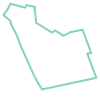

In [21]:
# here goes the exterior/outline of the poly's provided
zips["geometry"][1].exterior

In [22]:
# this si what we are trying to parse out of the poly's
zips["geometry"][1].exterior.coords.xy

(array('d', [-73.71132911125308, -73.7106837407401, -73.70869392379949, -73.70713084684176, -73.70419967936363, -73.70218528698231, -73.70308721830736, -73.70098278625547, -73.71371033246908, -73.714741836008, -73.71567895968894, -73.71867075939582, -73.71966142935703, -73.72082889049311, -73.72117809110456, -73.72250622247415, -73.72270447144122, -73.72183610276068, -73.72109289651769, -73.71775341502477, -73.71730957335735, -73.71534601002345, -73.71553103019596, -73.71541781535772, -73.71509806179287, -73.71132911125308]),
 array('d', [40.74947450816085, 40.75004039450918, 40.74875836557177, 40.749582740537946, 40.750169552569766, 40.744741887753854, 40.744547257355144, 40.73889569923034, 40.736174704865455, 40.73782936804115, 40.73962914915626, 40.74631499057428, 40.748945236431474, 40.751173028173014, 40.75232189224561, 40.753358470814895, 40.75373371438336, 40.75486513130315, 40.7562813418113, 40.75534755942338, 40.75595782995615, 40.75550893330126, 40.75506458072391, 40.75499844

###### Now we have to get the x and y's of these coordinates to individual columns
<a id = "coord_parsing"></a>

In [23]:
def getPolyCoords(row, coord_type, geom="geometry"):
    """ Returns the coordinates ('x' or 'y') of edges of a 
    Polygon exterior.
    """
    
    #parse the exterior of the coordinates 
    exterior = row[geom].exterior
    
    # assign appropriate values
    if coord_type == "x":
        #get the x coords
        return list(exterior.coords.xy[0])
    if coord_type == "y":
        return list(exterior.coords.xy[1])
    
# assign to new cols
zips["poly_x"] = zips.apply(getPolyCoords,
                            coord_type="x",
                            axis=1
                           )
zips["poly_y"] = zips.apply(getPolyCoords,
                            coord_type="y",
                            axis=1
                           )
print(zips.shape)
zips.head()

(262, 14)


,OBJECTID,postalCode,PO_NAME,STATE,borough,ST_FIPS,CTY_FIPS,BLDGpostal,@id,longitude,latitude,geometry,poly_x,poly_y
82,83,00083,Central Park,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.965573,40.782447,POLYGON ((-73.94922045816277 40.79690988348278...,"[-73.94922045816277, -73.95577163845807, -73.9...","[40.796909883482776, 40.787905470847036, 40.78..."
113,114,10001,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.996937,40.750215,POLYGON ((-74.00827017711134 40.75258714368449...,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756..."
123,124,10002,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.985688,40.716161,POLYGON ((-73.97441674489379 40.73642441865476...,"[-73.97441674489379, -73.97449300390227, -73.9...","[40.736424418654764, 40.7361171300957, 40.7356..."
121,122,10003,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-73.988841,40.731929,POLYGON ((-73.97986374196766 40.73497446573838...,"[-73.97986374196766, -73.98863956796875, -73.9...","[40.73497446573838, 40.72293224901508, 40.7241..."
146,147,10004,New York,NY,Manhattan,36,061,0,http://nyc.pediacities.com/Resource/PostalCode...,-74.045269,40.689870,POLYGON ((-74.04699098912498 40.69012472491997...,"[-74.04699098912498, -74.04723156029421, -74.0...","[40.69012472491997, 40.69040645829071, 40.6910..."


---
Add in Mercator Coordinates for Bokeh Tile

<a id = "merging_2"></a>
###### Now let's merge in the geo data into the original dataframe

In [0]:
def conv_poly_ys(row):
    
    import math
    r = 6378137.0
    
    return [math.log(math.tan(math.pi/4+math.radians(x) / 2))*r for x in row]

def conv_poly_xs(row):
    
    import math
    r = 6378137.0
    
    return [math.radians(x)*r for x in row]

zips["xs"] = zips.poly_x.map(conv_poly_xs)
zips["ys"] = zips.poly_y.map(conv_poly_ys)

In [25]:
set(df["postalCode"].astype('str', copy=False)).difference(set(zips["postalCode"]))

set()

In [26]:
#convert for this merge
df['postalCode'] = df["postalCode"].astype('str', copy=False)
# merge data
df = df.merge(
    zips[["postalCode", "poly_x", "poly_y", "xs", "ys"]],
    on="postalCode"
)
print(df.shape)
df.head()

(117505, 10)


,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys
0,08/20/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925646171696, -73.99621042550633)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."
1,08/20/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74923999191611, -73.99617072614878)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."
2,09/22/2015 12:00:00 AM,Other (Explain Below),10001,"(40.74667917800288, -73.99749536861394)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."
3,08/30/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74725219679941, -73.98766079482432)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."
4,05/31/2012 12:00:00 AM,Vacant Lot,10001,"(40.746039288497286, -73.99051930336279)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."


If you read in the dataframe (after saving and such).
The `poly_x`, `poly_y` columns tend to get coerced in to str type resulting in Bokeh not being able to read the coordinates. Additionally, Bokeh will not actually return an error (not helpful) but rather a blank screen with nothing rendered. So the below method will take 
care of this. 

###### Read in Data

``` python
pd.read_csv("rats_wrangled.csv)```

###### Default Rat Sightings Column

This column will be used to hold the values of rat sightings that the user wants to visualise and we are going to default it to the zip code level. 

```python
df["rat_sightings"] = df["zip_rat_sightings"]

```

###### Select Only Columns Necessary for Analysis.

```python 
df = df[[
    "Location Type", "postalCode", "Borough",
    "Neighborhood", "poly_x", "poly_y", 
    "zip_rat_sightings", "nhood_rat_sightings",
    "boro_rat_sightings", "rat_sightings"

]].drop_duplicates(subset="postalCode").reset_index(drop=True)
```

###### Define Function to Apply to GeoColumns to Correct Issue

The following function essentially calls eval on each item and returns it as the lists of lists that it was intended to be.

```python 
def convert_col(row):
    """ Convert each value of the column into list 
    from the string object.
    """
    
    return eval(row)
```
###### Run Function on GeoColumns

```python
df["poly_x"] = df["poly_x"].map(convert_col)
df["poly_y"] = df["poly_y"].map(convert_col)
```


---
Now we have the coordinates at the zip code level. Later on it will be desired to possibly also have the coordinates at the Neighborhood and the Borough level. 

Below the coordinates are going to be aggregated for each of the respective categories and added as additional columns

In [27]:
# grohp the data by Borough and concatenate all the corresponding coordinates associated with each
boro_data = df.groupby("Borough")[["xs", "ys"]].sum().reset_index().rename(columns={"xs":"Borough_xs", "ys":"Borough_ys"})

# merge in the coordinate for Boroughs
df = df.merge(boro_data)

nhood_data = df.groupby("Neighborhood")[["xs", "ys"]].sum().reset_index().rename(columns={"xs":"Neighborhood_xs", "ys":"Neighborhood_ys"})

# merge in the coordinates for Neighborhoods
df = df.merge(nhood_data)

df.head()

,Created Date,Location Type,postalCode,Location,Borough,Neighborhood,poly_x,poly_y,xs,ys,Borough_xs,Borough_ys,Neighborhood_xs,Neighborhood_ys
0,08/20/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74925646171696, -73.99621042550633)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."
1,08/20/2013 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74923999191611, -73.99617072614878)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."
2,09/22/2015 12:00:00 AM,Other (Explain Below),10001,"(40.74667917800288, -73.99749536861394)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."
3,08/30/2017 12:00:00 AM,3+ Family Apt. Building,10001,"(40.74725219679941, -73.98766079482432)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."
4,05/31/2012 12:00:00 AM,Vacant Lot,10001,"(40.746039288497286, -73.99051930336279)",Manhattan,Chelsea and Clinton,"[-74.00827017711134, -74.00762507843844, -74.0...","[40.752587143684494, 40.75427918134466, 40.756...","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422...."


---
Add in Seasons & Parse out Years

In [28]:
# not needed
del df["poly_x"], df["poly_y"]

# define seasons
winter = ["01", "02", "03"]
spring = ["04", "05", "06"]
summer = ["07", "08", "09"]
fall = ["10", "11", "12"]

def season(row):
    
    month = row.split("/")[0]

    if month in winter:
        return "winter"
    elif month in spring:
        return "spring"
    elif month in summer:
        return "summer"
    elif month in fall:
        return 'fall'
    else:
        return "NA"

seasons = df["Created Date"].map(season)
pd.Series(seasons).head()

0    summer
1    summer
2    summer
3    summer
4    spring
Name: Created Date, dtype: object

In [29]:
def year(row):
    
    return row.split("/")[2].split(' ')[0]

years = df["Created Date"].map(year)
pd.Series(years).head()

0    2013
1    2013
2    2015
3    2017
4    2012
Name: Created Date, dtype: object

In [30]:
del df["Created Date"]
df["Year"], df["Season"] = years, seasons
df.head()

,Location Type,postalCode,Location,Borough,Neighborhood,xs,ys,Borough_xs,Borough_ys,Neighborhood_xs,Neighborhood_ys,Year,Season
0,3+ Family Apt. Building,10001,"(40.74925646171696, -73.99621042550633)",Manhattan,Chelsea and Clinton,"[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....",2013,summer
1,3+ Family Apt. Building,10001,"(40.74923999191611, -73.99617072614878)",Manhattan,Chelsea and Clinton,"[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....",2013,summer
2,Other (Explain Below),10001,"(40.74667917800288, -73.99749536861394)",Manhattan,Chelsea and Clinton,"[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....",2015,summer
3,3+ Family Apt. Building,10001,"(40.74725219679941, -73.98766079482432)",Manhattan,Chelsea and Clinton,"[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....",2017,summer
4,Vacant Lot,10001,"(40.746039288497286, -73.99051930336279)",Manhattan,Chelsea and Clinton,"[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....","[-8238562.950607049, -8238491.138551269, -8238...","[4975916.533234529, 4976165.18054585, 4976422....",2012,spring


#### Exploratory Analysis
<a id = "eda"></a>

---

Bokeh Imports

In [31]:
!pip install bokeh

In [32]:
import pandas as pd
import numpy as np

from bokeh.io import curdoc

import yaml

from bokeh.io import (
    output_notebook,
    show
)

from bokeh.plotting import (
    Column,
    figure,
    gridplot,
    Row
)

from bokeh.themes import Theme
from bokeh.layouts import widgetbox
from bokeh.palettes import Blues9, OrRd9
from bokeh.transform import jitter
from bokeh.tile_providers import CARTODBPOSITRON

from bokeh.models import (
    BasicTicker, ColumnDataSource, ColorBar,
    ColorMapper, CustomJS, Div,
    HBar, HoverTool, LinearColorMapper,
    LogColorMapper, MultiSelect, PrintfTickFormatter,
    Select
)

output_notebook()

Loading BokehJS ...

###### Interactive Bar Chart Analysis

Which Borough is the worst? Which neighborhood? Which zip code? Was any year worst than others? What about seasons?

In [33]:
def modify_bar_doc(doc):
    
    df = pd.read_csv("./data/Rat_Sightings.csv")
    
    def bar_chart(var="Borough", year="All", season="All"):

        """ Takes in a dataframe and a column name in a string format as inputs
        and generates a simple bar chart with hover capability and color mapping
        the most intense categories. 
        """
        
        if year == "All" and season =="All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                        )

        elif year != "All" and season == "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                        )
            
        elif year != "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                        )
          
        elif year == "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                        )
            
        else:
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                        )
        
        # add in the percentages
        groupeddf["perc"] = (groupeddf["n"]/groupeddf["n"].sum())*100

        # assign names of columns
        groupeddf.columns = [var, var+"_rat_sightings", "perc"]

        # keep names as list
        names = [*groupeddf.columns]

        # keep unique values of col_name
        uniq_vals = [*groupeddf[var].unique()]

        # instantiate color mapper
        mapper = LogColorMapper(palette=Blues9[::-1])

        # instantiate figure
        p = figure(
            y_range=uniq_vals,
            title = "Rat Sightings by %s" %var
        )

        # fill figure
        p.hbar(
            y = var,
            right=names[1],
            height=0.9,
            source=ColumnDataSource(data=groupeddf),
            alpha=0.6,
            hover_alpha=0.9,
            fill_color = {
                "field":names[1],
                "transform":mapper
            }
        )

        # add hover tool
        p.add_tools(HoverTool(
            tooltips =[
                ("%s" %var, "@%s" %var),
                ("%s" %names[1],"@%s"%(names[1])),
                ("Percentage of Sightings", "@perc %")
            ],
            point_policy="follow_mouse"
        ))

        return p

    # create a select for users
    var_select = Select(value="Borough",
                        options = ["Borough", "postalCode",
                                   "Neighborhood", "Location Type",
                                   "Year", "Season"
                                  ],
                        title = "Select the Variable to View: "
                       )
    year_select = Select(value="All",
                         options=[*df["Year"].unique()]+["All"],
                         title="Select a year to view: "
                        )
    season_select = Select(value="All", 
                           options=[*df["Season"].unique()]+["All"],
                           title="Select a season to view: "
                          )

    # create interactivity component
    def update_plot(attr, old, new):

        layout.children[1] = bar_chart(var=var_select.value,
                                       year=year_select.value,
                                       season=season_select.value
                                      )

    # add in interactivity component
    var_select.on_change("value", update_plot)
    year_select.on_change("value", update_plot)
    season_select.on_change("value", update_plot)
    
    # define layout
    layout = Column(Column(var_select, year_select, season_select), bar_chart())

    doc.add_root(layout)

    doc.theme = Theme(json=yaml.load(
            """ attrs:
                    Figure:
                        background_fill_color: "#DDDDDD"
                        outline_line_color: white
                        toolbar_location: above
                        height: 500
                        width: 800
            """
        ))

show(modify_bar_doc)

###### Interactive Scatter Plot Analysis?

How were rat sightings distributed among location types within boroughs, neighborhoods, and zip codes?

In [34]:
def modify_scatter(doc):
    
    df = pd.read_csv("./data/Rat_Sightings.csv")


    def var_loc_scatter(var="Borough", loc_var = "Location Type", year="All", season="All"):

        """ This function takes in the dataframe, variable, and location
        type variable as inputs. The function will group the dataframe by
        the specified variable and location type to find the counts of various
        location types for each unique value of the variable. The function
        will then generate a scatter plot and return the resulting dataframe.
        """
        
        if year == "All" and season =="All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )

        elif year != "All" and season == "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )
            
        elif year != "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )
          
        elif year == "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )
            
        else:
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )

        # get total percentages
        groupeddf["total_perc"] = (groupeddf.rat_sightings/groupeddf.rat_sightings.sum())*100

        # get local percentages
        # use map?

        # create a list of the unique values
        uniq_vals = [*groupeddf[var].unique()]

        # create color mapper
        mapper = LogColorMapper(
            palette=Blues9[::-1]
        )

        # instantiate figure
        p = figure(
            y_range=uniq_vals
        )

        p.circle(
            x = "rat_sightings",
            y = jitter(var, width=0.6, range=p.y_range),
            source=ColumnDataSource(data=groupeddf),
            alpha=0.6,
            size=30,
            hover_alpha=0.9,
            fill_color = {
                "field":"rat_sightings",
                "transform":mapper
            }
        )

        p.add_tools(HoverTool(
            tooltips=[
                ("%s" %var, "@%s" %var),
                ("Location Type", "@loc_type"),
                ("Num. of Rat Sightings", "@rat_sightings"),
                ("Percentage of Rat Sightings within the %ss" %var,
                 "@total_perc %")
            ]
        ))

        return p

    # create a select for users
    var_select = Select(value="Borough",
                        options = ["Borough", "postalCode",
                                   "Neighborhood",
                                   "Year", "Season"
                                  ],
                        title = "Select the Variable to View: "
                       )
    year_select = Select(value="All",
                         options=[*df["Year"].unique()]+["All"],
                         title="Select a year to view: "
                        )
    season_select = Select(value="All", 
                           options=[*df["Season"].unique()]+["All"],
                           title="Select a season to view: "
                          )

    # create interactivity components
    def update_plot(attr, old, new):

        layout.children[1] = var_loc_scatter(var=var_select.value,
                                             year=year_select.value,
                                             season=season_select.value
                                            )

    # add in interactivity component
    var_select.on_change('value', update_plot)
    year_select.on_change("value", update_plot)
    season_select.on_change("value", update_plot)

    layout = Column(Column(var_select, year_select, season_select), var_loc_scatter())

    doc.add_root(layout)
    
    doc.theme = Theme(json=yaml.load(
        """ attrs:
                Figure:
                    background_fill_color: "#DDDDDD"
                    outline_line_color: white
                    toolbar_location: above
                    height: 500
                    width: 800
        """
    ))
    
show(modify_scatter)

A heatmap of the same data above to get a different visual.

In [35]:
def modify_heatmap(doc):
    
    df = pd.read_csv("./data/Rat_Sightings.csv")
    
    def var_loc_heatmap(df=df, var="Borough", loc_var="Location Type", year="All", season="All"):

        """
            Creates a heatmap for each class in var (Borough, Neighborhood, or Zip Code)
            and determines which location types are the of the highest 
            intensity for each. Essentially a recreation of the scatter
            plot but with a heatmap instead of circles. 
        """

        # group by
        if year == "All" and season =="All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )

        elif year != "All" and season == "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )
            
        elif year != "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )
          
        elif year == "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )
            
        else:
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby([var,loc_var])   
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             loc_var:"loc_type","n":"rat_sightings"
                            })
                        )

        # get total percentages
        groupeddf["total_perc"] = (groupeddf.rat_sightings/groupeddf.rat_sightings.sum())*100


        # get unique value names
        loc_types = [*groupeddf["loc_type"].unique()]
        uniq_vals = [*groupeddf[var].unique()]

        # now add in percentages to give more information to user
        # get the total values

        sum_data = pd.DataFrame(
            groupeddf.groupby(var).rat_sightings.sum()
        )

        col_name = "total_%s_sights" %var
        sum_data.columns = [col_name]


        # merge the totals in to the dataframe
        """ Sure this can be applied to the dataframe in some fashion but opting
        for the conceptually easier solution here. 
        """
        groupeddf = groupeddf.merge(sum_data.reset_index())

        # get percentages for each location type
        perc_name = "perc_sights"
        groupeddf[perc_name] = (
            groupeddf["rat_sightings"]/groupeddf[col_name])*100

        # instantiate color mapper
        mapper = LogColorMapper(palette=Blues9[::-1])

        # instantiate plot
        p = figure(y_range=uniq_vals, x_range=loc_types)

        # specify plot parameters
        p.grid.grid_line_color = None
        p.axis.axis_line_color = None
        p.axis.major_tick_line_color = None
        p.axis.major_label_text_font_size="7pt"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = pi/3

        # fill plot with data
        p.rect(
            x="loc_type",
            y=var,
            width=1,
            height=1,
            source=ColumnDataSource(data=groupeddf),
            alpha= 0.6,
            hover_alpha=0.9,
            fill_color = {
                "field":"rat_sightings",
                "transform":mapper
            }
        )

        p.add_tools(HoverTool(
            tooltips = [
                ("%s" %var, "@%s" %var),
                ("Location Type", "@loc_type"),
                ("Num. of Rat Sightings","@rat_sightings"),
                ("Perc. of Rat Sightings Across %ss" %var,"@perc_sights %")
            ],
            point_policy="follow_mouse"
        ))

        return p

    var_select = Select(value="Borough",
                            options=["Borough", "Neighborhood",
                                     "postalCode", "Year",
                                     "Season"
                                    ],
                            title="Select the Variable to View: "
                           )
    year_select = Select(value="All",
                         options=[*df["Year"].unique()]+["All"],
                         title="Select a year to view: "
                        )
    season_select = Select(value="All", 
                           options=[*df["Season"].unique()]+["All"],
                           title="Select a season to view: "
                          )

    # create interactivity components
    def update_plot(attr, old, new):

        layout.children[1] = var_loc_heatmap(var=var_select.value,
                                             year=year_select.value,
                                             season=season_select.value
                                            )

    # add in interactivity component
    var_select.on_change('value', update_plot)
    year_select.on_change("value", update_plot)
    season_select.on_change("value", update_plot)

    layout = Column(Column(var_select, year_select, season_select), var_loc_heatmap())

    doc.add_root(layout)

    doc.theme = Theme(json=yaml.load(
        """ attrs:
                Figure:
                    background_fill_color: "#DDDDDD"
                    outline_line_color: white
                    toolbar_location: above
                    height: 500
                    width: 800
        """
    ))
    
show(modify_heatmap)

Look at any two variables you'd like instead of just the location types. 

In [36]:
def modify_divariate_scatter(doc):

    df = pd.read_csv("./data/Rat_Sightings.csv")

    def var_var_scatter(df=df, var1="Borough", var2="Neighborhood", year="All", season="All"):

        """
            Allows the user to select whichever variables
            from the dataset for comparison in the form 
            of a scatter plot.
        """

        # we want the var1 to be the least granular variable
        name1, name2 = var1,var2

        # get the number of classes
        n_classes1 = df[var1].nunique()
        n_classes2 = df[var2].nunique()

        # if the num of classes in var2 is less then reassign variables
        if n_classes2 < n_classes1:
            var1 = name2
            var2 = name1

        # group by
        if year == "All" and season =="All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )

        elif year != "All" and season == "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )
            
        elif year != "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )
          
        elif year == "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )
            
        else:
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )

        # get unique values for both vars
        uniq_vals1 = [*groupeddf[var1].unique()]
        uniq_vals2 = [*groupeddf[var2].unique()]

        # now add in percentages to give more information to user
        # get the total values

        sum_data = pd.DataFrame(
            groupeddf.groupby(var1)["rat_sightings"].sum()
        )

        col_name = "total_%s_sights" %var1
        sum_data.columns = [col_name]


        # merge the totals in to the dataframe
        """ Sure this can be applied to the dataframe in some fashion but opting
        for the conceptually easier solution here. 
        """
        groupeddf = groupeddf.merge(sum_data.reset_index())

        # get percentages for each location type
        perc_name = "perc_sights"
        groupeddf[perc_name] = (
            groupeddf["rat_sightings"]/groupeddf[col_name])*100

        # create color mapper
        mapper = LogColorMapper(
            palette=Blues9[::-1]
        )

        # instantiate figure
        p = figure(
            plot_width=800,
            plot_height=600,
            y_range=uniq_vals1
        )

        p.circle(
            x = "rat_sightings",
            y = jitter(var1, width=0.6, range=p.y_range),
            source=ColumnDataSource(data=groupeddf),
            alpha=0.6,
            size=30,
            hover_alpha=0.9,
            fill_color = {
                "field":"rat_sightings",
                "transform":mapper
            }
        )

        p.add_tools(HoverTool(
            tooltips=[
                ("%s" %var1, "@%s" %var1),
                ("%s" %var2, "@%s" %var2),
                ("Num. of Rat Sightings", "@rat_sightings"),
                ("Percentage of Rat Sightings within the %ss" %var1,
                 "@perc_sights %")
            ]
        ))

        return p

    # define variable selects
    var1_select = Select(value="Borough",
                         options=[*df.columns],
                         title="Select a variable: "
                        )
    var2_select = Select(value="Neighborhood",
                         options=[*df.columns],
                         title="Select a variable: "
                        )
    year_select = Select(value="All",
                         options=[*df["Year"].unique()]+["All"],
                         title="Select a year to view: "
                        )
    season_select = Select(value="All", 
                           options=[*df["Season"].unique()]+["All"],
                           title="Select a season to view: "
                          )

    # define interactivity
    def update_plot(attr, old, new):

        layout.children[1] = var_var_scatter(var1=var1_select.value,
                                             var2=var2_select.value,
                                             year=year_select.value,
                                             season=season_select.value
                                            )

    # inc interactivity
    var1_select.on_change("value", update_plot)
    var2_select.on_change("value", update_plot)
    year_select.on_change("value", update_plot)
    season_select.on_change("value", update_plot)

    layout=Column(
        Row(
            Column(var1_select, var2_select),
            Column(year_select, season_select)
        ),
        var_var_scatter()
    )

    doc.add_root(layout)

    doc.theme = Theme(json=yaml.load(
            """ attrs:
                    Figure:
                        background_fill_color: "#DDDDDD"
                        outline_line_color: white
                        toolbar_location: above
                        height: 500
                        width: 800
            """
        ))
    
show(modify_divariate_scatter)

Same deal.

In [37]:
def modify_divar_heatmap(doc):
    
    df = pd.read_csv("./data/Rat_Sightings.csv")
    
    def var_var_heatmap(df=df, var1="Borough", var2="Neighborhood", year="All", season="All"):

        """
        """
        # we want the var1 to be the least granular variable
        name1, name2 = var1,var2

        # get the number of classes
        n_classes1 = df[var1].nunique()
        n_classes2 = df[var2].nunique()

        # if the num of classes in var2 is less then reassign variables
        if n_classes2 < n_classes1:
            var1 = name2
            var2 = name1

        # group by
        if year == "All" and season =="All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )

        elif year != "All" and season == "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )
            
        elif year != "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Year == '%s'" %year)
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )
          
        elif year == "All" and season != "All":
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .query("Season == '%s'" %season)
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )
            
        else:
            
            #group dataframe by indicated column name and rename columns
            groupeddf = (df
                         .assign(n=0)
                         .groupby([var1, var2])
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {
                             "n":"rat_sightings"
                            })
                        )
            
        # get unique value names
        uniq_vals1 = [*groupeddf[var1].unique()]
        uniq_vals2 = [*groupeddf[var2].unique()]

        # now add in percentages to give more information to user
        # get the total values

        # group by variable with less classes
        sum_data = pd.DataFrame(
            groupeddf.groupby(var1).rat_sightings.sum()
        )

        col_name = "total_%s_sights" %var1
        sum_data.columns = [col_name]


        # merge the totals in to the dataframe
        """ Sure this can be applied to the dataframe in some fashion but opting
        for the conceptually easier solution here. 
        """
        groupeddf = groupeddf.merge(sum_data.reset_index())

        # get percentages for each location type
        perc_name = "perc_sights"
        groupeddf[perc_name] = (
            groupeddf["rat_sightings"]/groupeddf[col_name])*100


        # instantiate source
        source = ColumnDataSource(groupeddf)

        # instantiate color mapper
        mapper = LogColorMapper(palette=Blues9[::-1])

        # instantiate plot
        p = figure(
            plot_width=800, plot_height=600,
            y_range=uniq_vals1, x_range=uniq_vals2
        )

        # specify plot parameters
        p.grid.grid_line_color = None
        p.axis.axis_line_color = None
        p.axis.major_tick_line_color = None
        p.axis.major_label_text_font_size="7pt"
        p.axis.major_label_standoff = 0
        p.xaxis.major_label_orientation = pi/3

        # fill plot with data
        p.rect(
            x=var2,
            y=var1,
            width=1,
            height=1,
            source=source,
            alpha= 0.6,
            hover_alpha=0.9,
            fill_color = {
                "field":"rat_sightings",
                "transform":mapper
            }
        )

        p.add_tools(HoverTool(
            tooltips = [
                ("%s" %var1, "@%s" %var1),
                ("%s" %var2, "@%s" %var2),
                ("Num. of Rat Sightings","@rat_sightings"),
                ("Perc. of Rat Sightings Across %ss" %var1,"@perc_sights %")
            ],
            point_policy="follow_mouse"
        ))

        return p

    # define variable selects
    var1_select = Select(value="Borough",
                         options=[*df.columns],
                         title="Select a variable: "
                        )
    var2_select = Select(value="Neighborhood",
                         options=[*df.columns],
                         title="Select a variable: "
                        )
    year_select = Select(value="All",
                         options=[*df["Year"].unique()]+["All"],
                         title="Select a year to view: "
                        )
    season_select = Select(value="All", 
                           options=[*df["Season"].unique()]+["All"],
                           title="Select a season to view: "
                          )

    # define interactivity
    def update_plot(attr, old, new):

        layout.children[1] = var_var_heatmap(var1=var1_select.value,
                                             var2=var2_select.value,
                                             year=year_select.value,
                                             season=season_select.value
                                            )

    # inc interactivity
    var1_select.on_change("value", update_plot)
    var2_select.on_change("value", update_plot)
    year_select.on_change("value", update_plot)
    season_select.on_change("value", update_plot)

    layout=Column(
        Row(
            Column(var1_select, var2_select),
            Column(year_select, season_select)
        ),
        var_var_heatmap()
    )

    doc.add_root(layout)

    doc.theme = Theme(json=yaml.load(
            """ attrs:
                    Figure:
                        background_fill_color: "#DDDDDD"
                        outline_line_color: white
                        toolbar_location: above
                        height: 500
                        width: 800
            """
        ))
    
show(modify_divar_heatmap)

Let's view this data interactively on a map.

In [38]:
def choro_map(doc):
    
    df = pd.read_csv("./data/Rat_Sightings.csv")

    def make_map(var="postalCode", year="All", season="All"):
        
        def filter_years_seasons(df=df, season=season, year=year):
    
            if year == "All" and season =="All":

                #group dataframe by indicated column name and rename columns
                df = (df
                            )

            elif year != "All" and season == "All":

                #group dataframe by indicated column name and rename columns
                df = (df
                      .query("Year == '%s'" %year)
                     )

            elif year != "All" and season != "All":

                # select cases for user-selected year and season
                df = (df
                     .query("Year == '%s'" %year)
                     .query("Season == '%s'" %season)
                    )

            elif year == "All" and season != "All":

                # only extract cases for the user-selected season
                df = (df
                      .query("Season == '%s'" %season)    
                     )

            else:

                # just set it to itself if user-error occurs
                df = df   


            return df
        
        new_df = filter_years_seasons()

        if var=="postalCode":

            groupeddf = (new_df
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {"n":"Rat_Sightings"})
                         .merge(df[["postalCode", "Neighborhood",
                                    "Borough", "xs", "ys"
                                   ]])
                         .drop_duplicates(subset=[var])
                         .reset_index(drop=True)
                        )

        elif var == "Neighborhood":

            groupeddf = (new_df
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {"n":"Rat_Sightings"})
                         .merge(df[["Neighborhood", "Borough",
                                    "Neighborhood_xs", "Neighborhood_ys"
                                   ]])
                         .drop_duplicates(subset=[var])
                         .reset_index(drop=True)
                         .rename(columns={"Neighborhood_xs":"xs", "Neighborhood_ys":"ys"})
                        )

        elif var == "Borough":
            groupeddf = (new_df
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {"n":"Rat_Sightings"})
                         .merge(df[["Borough", 
                                    "Borough_xs", "Borough_ys"
                                   ]])
                         .drop_duplicates(subset=[var])
                         .reset_index(drop=True)
                         .rename(columns={"Borough_xs":"xs", "Borough_ys":"ys"})
                        )
        else:

            groupeddf = (new_df
                         .assign(n=0)
                         .groupby(var)
                         .n
                         .count()
                         .reset_index()
                         .rename(columns = {"n":"Rat_Sightings"})
                         .merge(df[["postalCode", "Neighborhood",
                                    "Borough", "xs", "ys"
                                   ]])
                         .drop_duplicates(subset=[var])
                         .reset_index(drop=True)
                        )



        # instantiate the color mapper
        color_mapper = LogColorMapper(
            palette=OrRd9[::-1]
        )

        p = figure(
            x_range=(-8400000,-8100000),
            y_range=(4950000, 5000000),
            x_axis_type = "mercator",
            y_axis_type="mercator",
            plot_height=1200,
            plot_width=1000
        )
        p.axis.visible = False
        p.grid.grid_line_color = None
        p.add_tile(CARTODBPOSITRON)

        p.grid.grid_line_color = None

        p.patches(
            "xs",
            "ys",
            source=ColumnDataSource(data=groupeddf),
            fill_color = {
                "field":"Rat_Sightings",
                "transform":color_mapper
            },
            fill_alpha=0.6
        )
        
        p.add_tools(HoverTool(tooltips=[
            ("Number of Rat Sightings: ", "@Rat_Sightings"),
            ("%s" %var, "@%s" %var)
        ]))

        return p

    year_select = Select(value="All",
                         options=[*df["Year"].unique()]+["All"],
                         title="Select a year to view: "
                        )
    season_select = Select(value="All", 
                           options=[*df["Season"].unique()]+["All"],
                           title="Select a season to view: "
                          )


    def update_plot(attr, old, new):

        layout.children[1] = make_map(
                                      year=year_select.value,
                                      season=season_select.value
                                     )

    year_select.on_change("value", update_plot)
    season_select.on_change("value", update_plot)

    layout = Column(Column(year_select, season_select), make_map())

    doc.add_root(layout)

    doc.theme = Theme(json=yaml.load(
            """ attrs:
                    Figure:
                        background_fill_color: "#DDDDDD"
                        outline_line_color: white
                        toolbar_location: above
                        height: 500
                        width: 800
            """
        ))
    

show(choro_map)